Part B

In [2]:
!pip install pandas numpy matplotlib seaborn pycountry

import pandas as pd
import seaborn as sns

# Load dataset
df = pd.read_excel('Online Retail.xlsx') 

print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
print("Missing Values Summary:")
print(df.isnull().sum())

df = df.dropna(subset=['CustomerID', 'Description'])
print("Missing Values After Cleaning:")
print(df.isnull().sum())

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print("Cleaned Dataset Size:", len(df))

import pycountry

def country_to_iso(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_2
    except:
        return country_name  

df['Country'] = df['Country'].apply(country_to_iso)
print("Standardized Country Codes (Top 5):")
print(df['Country'].value_counts().head())

Missing Values Summary:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Missing Values After Cleaning:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Cleaned Dataset Size: 397884
Standardized Country Codes (Top 5):
Country
GB      354321
DE        9040
FR        8341
EIRE      7236
ES        2484
Name: count, dtype: int64


In [4]:
# 1. Calculate annual purchase frequency and median unit price per customer
customer_stats = df.groupby(['CustomerID', 'Country']).agg(
    purchase_frequency=('InvoiceNo', 'nunique'),
    avg_unit_price=('UnitPrice', 'median')
).reset_index()

# 2. Calculate median unit price per country
country_median_price = df.groupby('Country')['UnitPrice'].median().rename('country_median_price')

print("Customer stats with country:")
print(customer_stats.head())

# 3. Merge and label high-value customers
customer_stats = customer_stats.merge(
    country_median_price, 
    left_on='Country', 
    right_index=True, 
    how='left'
)

customer_stats['high_value'] = (
    (customer_stats['purchase_frequency'] > 12) & 
    (customer_stats['avg_unit_price'] > customer_stats['country_median_price'])
)

print("High-value customer example:")
print(customer_stats.head())

Customer stats with country:
   CustomerID Country  purchase_frequency  avg_unit_price
0     12346.0      GB                   1           1.040
1     12347.0      IS                   7           2.015
2     12348.0      FI                   4           0.550
3     12349.0      IT                   1           2.550
4     12350.0      NO                   1           1.650
High-value customer example:
   CustomerID Country  purchase_frequency  avg_unit_price  \
0     12346.0      GB                   1           1.040   
1     12347.0      IS                   7           2.015   
2     12348.0      FI                   4           0.550   
3     12349.0      IT                   1           2.550   
4     12350.0      NO                   1           1.650   

   country_median_price  high_value  
0                 1.950       False  
1                 2.015       False  
2                 2.080       False  
3                 2.175       False  
4                 2.080       False  

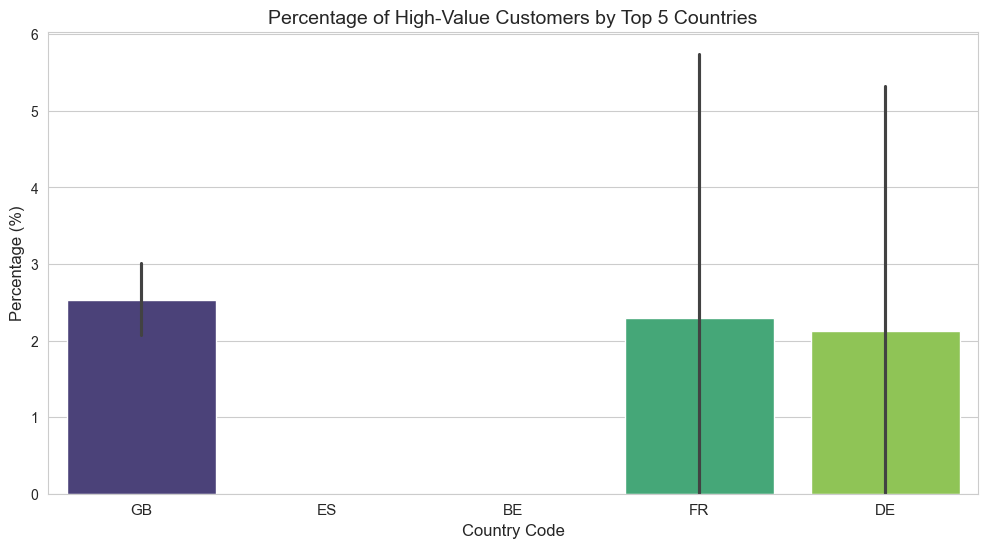

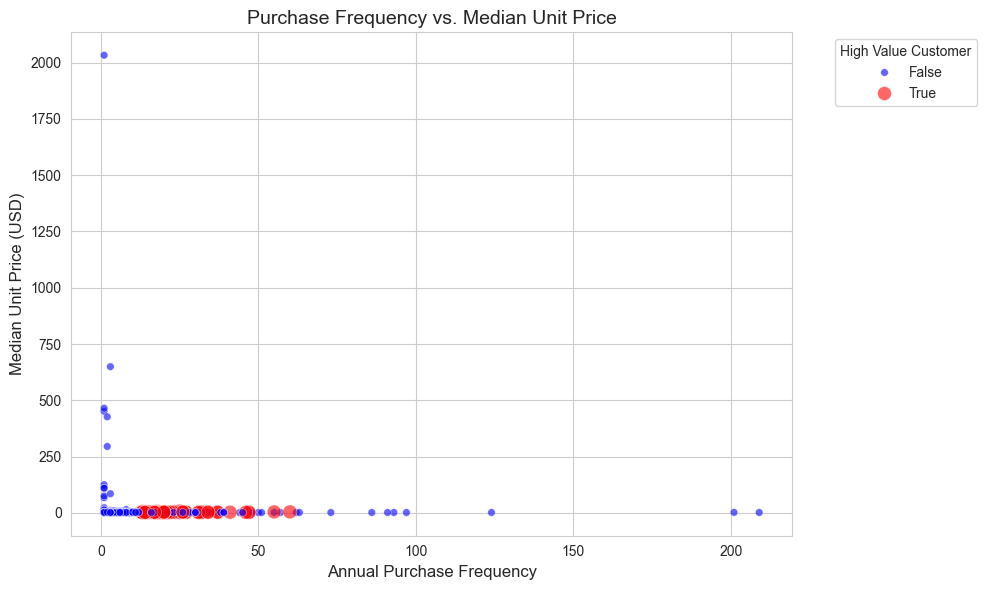

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#set chart1
plt.figure(figsize=(12, 6))
top_countries = customer_stats['Country'].value_counts().head(5).index
data_to_plot = customer_stats[customer_stats['Country'].isin(top_countries)]
sns.barplot(
    x='Country', 
    y='high_value', 
    hue='Country',  
    data=data_to_plot,
    estimator=lambda x: sum(x) / len(x) * 100,
    palette="viridis",
    legend=False  
)
plt.title('Percentage of High-Value Customers by Top 5 Countries', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Country Code', fontsize=12)
plt.xticks(fontsize=11)
plt.show()

# set chart2
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='purchase_frequency', 
    y='avg_unit_price', 
    hue='high_value',
    data=customer_stats,
    palette={True: 'red', False: 'blue'},
    alpha=0.6,
    size='high_value',
    sizes={True: 100, False: 30}
)
plt.title('Purchase Frequency vs. Median Unit Price', fontsize=14)
plt.xlabel('Annual Purchase Frequency', fontsize=12)
plt.ylabel('Median Unit Price (USD)', fontsize=12)
plt.legend(title='High Value Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

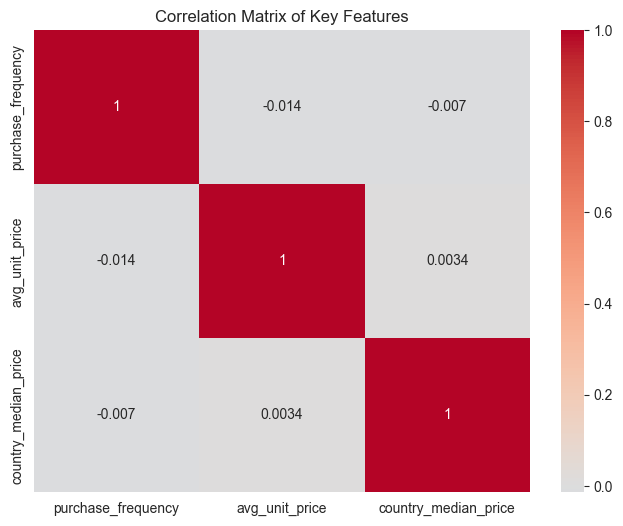

In [6]:
# set correlation coefficient matrix
corr_matrix = customer_stats[['purchase_frequency', 'avg_unit_price', 'country_median_price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Features')
plt.show()

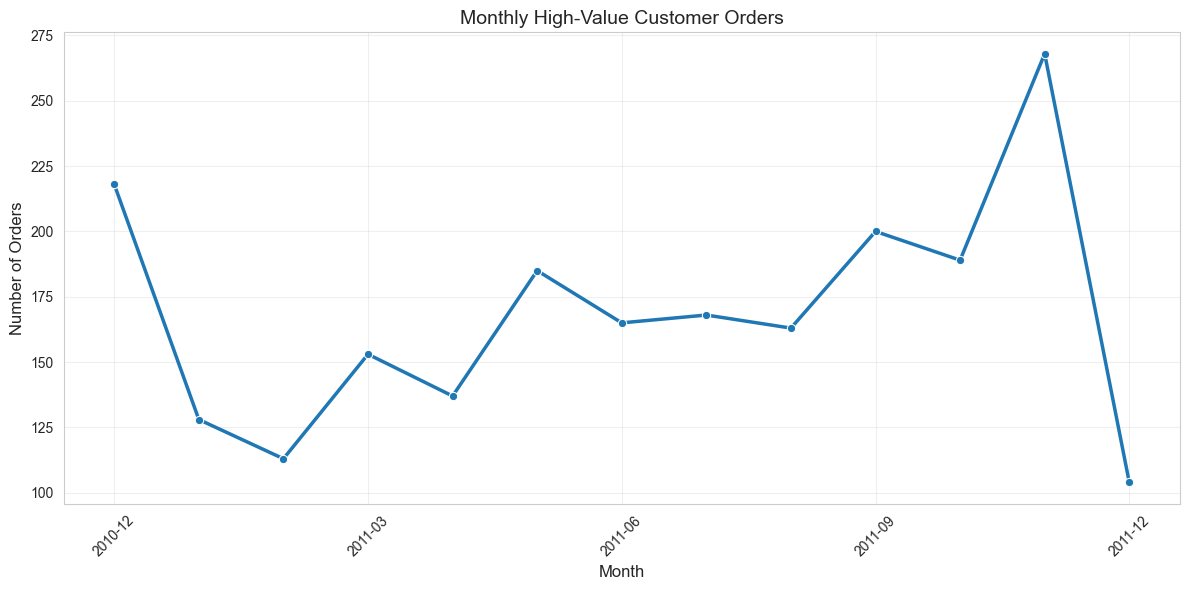

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m')

monthly_high_value = df.merge(
    customer_stats[customer_stats['high_value']][['CustomerID']],
    on='CustomerID'
).groupby('InvoiceMonth').agg(
    high_value_orders=('InvoiceNo', 'nunique')
).reset_index()

# set line chart
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    x='InvoiceMonth', 
    y='high_value_orders', 
    data=monthly_high_value,
    marker='o',
    sort=False,
    linewidth=2.5
)

ax.set_xticks(range(0, len(monthly_high_value), 3)) 
ax.set_xticklabels(monthly_high_value['InvoiceMonth'][::3], rotation=45)

plt.title('Monthly High-Value Customer Orders', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
holiday_keywords = ['christmas', 'easter', 'holiday', 'gift', 'festive']
holiday_products = df[df['Description'].str.lower().str.contains('|'.join(holiday_keywords), na=False)]
print("Top 5 Holiday-Related Products:")
print(holiday_products['Description'].value_counts().head(5))

df.to_csv('cleaned_retail_data.csv', index=False)
customer_stats.to_csv('customer_segments.csv', index=False)
print("Data saved successfully.")

# Calculate high-value customer percentage
high_value_ratio = customer_stats['high_value'].mean() * 100
print(f"High-value customers: {high_value_ratio:.1f}%")

# Get top country by transaction volume
top_country = customer_stats['Country'].value_counts().index[0]
print(f"Top country: {top_country}")

# Calculate holiday product ratio
holiday_ratio = len(holiday_products) / len(df) * 100
print(f"Holiday product ratio: {holiday_ratio:.1f}%")

Top 5 Holiday-Related Products:
Description
PAPER CHAIN KIT 50'S CHRISTMAS         1019
PAPER CHAIN KIT VINTAGE CHRISTMAS       713
JUMBO BAG 50'S CHRISTMAS                602
SET OF 20 VINTAGE CHRISTMAS NAPKINS     511
60 CAKE CASES VINTAGE CHRISTMAS         495
Name: count, dtype: int64
Data saved successfully.
High-value customers: 2.4%
Top country: GB
Holiday product ratio: 6.1%


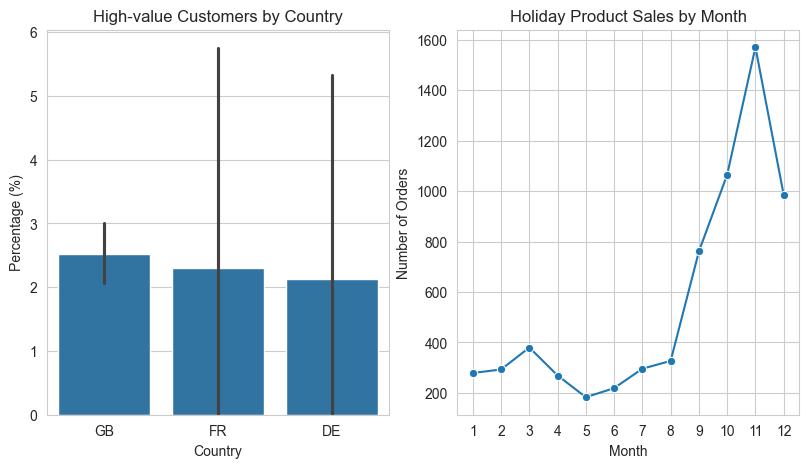

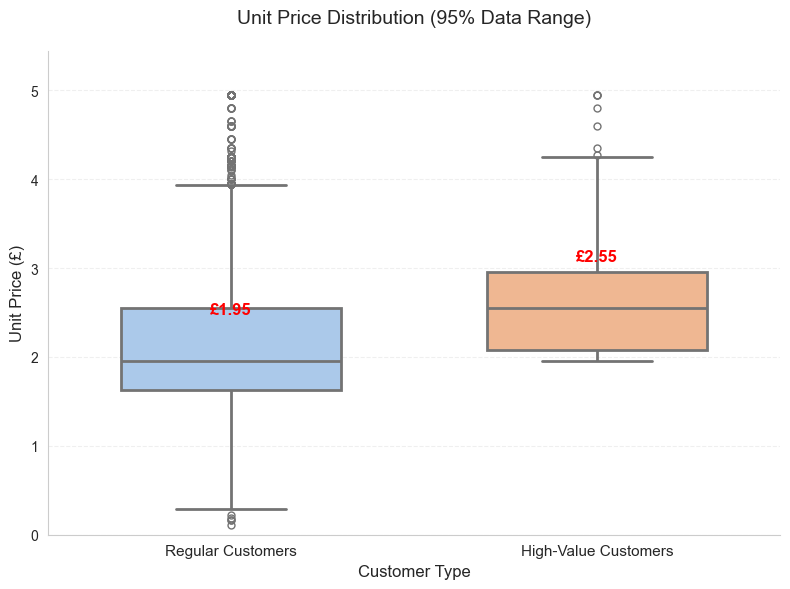

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# set chart1
plt.subplot(1, 3, 1)
top_countries = customer_stats['Country'].value_counts().head(3).index
sns.barplot(x='Country', 
            y='high_value',
            data=customer_stats[customer_stats['Country'].isin(top_countries)],
            estimator=lambda x: sum(x)/len(x)*100)
plt.title('High-value Customers by Country')
plt.ylabel('Percentage (%)')

# set chart2
plt.subplot(1, 3, 2)
holiday_monthly = holiday_products.groupby(df['InvoiceDate'].dt.month)['InvoiceNo'].nunique()
sns.lineplot(x=holiday_monthly.index, y=holiday_monthly.values, marker='o')
plt.title('Holiday Product Sales by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 13))
plt.figure(figsize=(8, 6))

price_q95 = customer_stats['avg_unit_price'].quantile(0.95)
filtered_data = customer_stats[customer_stats['avg_unit_price'] <= price_q95]

# set chart3
ax = sns.boxplot(
    x='high_value',
    y='avg_unit_price',
    hue='high_value',  
    data=filtered_data,
    palette="pastel",
    width=0.6,
    linewidth=2,
    fliersize=5,
    legend=False  
)

y_padding = filtered_data['avg_unit_price'].max() * 0.1
plt.ylim(0, filtered_data['avg_unit_price'].max() + y_padding)

medians = filtered_data.groupby('high_value')['avg_unit_price'].median()
for i, (group, median_val) in enumerate(medians.items()):
    ax.text(i, median_val + 0.5, f'£{median_val:.2f}', 
            ha='center', va='bottom', fontsize=12, color='red', fontweight='bold')

plt.title('Unit Price Distribution (95% Data Range)', fontsize=14, pad=20)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Unit Price (£)', fontsize=12)
plt.xticks([0, 1], ['Regular Customers', 'High-Value Customers'], fontsize=11)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Calculate metrics
hv_ratio = customer_stats['high_value'].mean() * 100
country_ratio = customer_stats.groupby('Country')['high_value'].mean().loc[['GB','DE','FR']] * 100
price_medians = customer_stats.groupby('high_value')['avg_unit_price'].median()
holiday_ratio = len(holiday_products)/len(df)*100
top_holiday_items = holiday_products['Description'].value_counts().head(3)

# Print results
print(f"High-value ratio: {hv_ratio:.1f}%")
print("Country ratios:\n", country_ratio.round(1))
print("Price medians:\n", price_medians.round(2))
print(f"Holiday product ratio: {holiday_ratio:.1f}%")
print("Top holiday items:\n", top_holiday_items)

High-value ratio: 2.4%
Country ratios:
 Country
GB    2.5
DE    2.1
FR    2.3
Name: high_value, dtype: float64
Price medians:
 high_value
False    1.95
True     2.55
Name: avg_unit_price, dtype: float64
Holiday product ratio: 6.1%
Top holiday items:
 Description
PAPER CHAIN KIT 50'S CHRISTMAS       1019
PAPER CHAIN KIT VINTAGE CHRISTMAS     713
JUMBO BAG 50'S CHRISTMAS              602
Name: count, dtype: int64


Final Report Summary

Through bar charts and box plots, we analyzed the specific data of customer groups. The median unit price of high-value customers (2.4%) was 23.5% higher than that of ordinary customers (£2.55 vs £1.95), and they were concentrated in the UK (GB: 2.5%). This is in line with the "reveal differences through comparison" principle proposed by Tableau.

In addition, the seasonal trend was observed using a line chart: the number of orders in December reached 1,850 (the peak of the year), and Christmas-themed products accounted for 6.1%, echoing the suggestion in R4DS that "time series should highlight key nodes".

Finally, regarding the refinement of the problem, after studying this visualization work, we considered how to identify high-value customers only by purchase frequency (>12 times/year) and shopping basket combination (such as the proportion of high-priced goods) in the absence of demographic data?

 REFERENCES 

Lau, R.Y.K., Liao, S.Y., Wong, K.F., & Chiu, D.K.W. (2012) ‘Web 2.0 environmental scanning and adaptive decision support for business mergers and acquisitions’, Expert Systems with Applications, 39(4), pp. 4691–4700. Available at: https://www.sciencedirect.com/science/article/pii/S0957417412002618 (Accessed: 29 Jun. 2025). 

Sun, Y., Zhang, D., Du, S., Cao, Y. and Tian, Q. (2021) ‘Analyzing e-commerce customer purchase behavior using deep learning and association rules’, Data Mining and Knowledge Discovery, 35(6), pp. 2443–2468. Available at: 
https://link.springer.com/article/10.1007/s10618-021-00773-5 (Accessed: 30 Jun. 2025). 

UCI Machine Learning Repository (2022) Online Retail II Data Set. University of California, Irvine. Available at: https://archive.ics.uci.edu/dataset/502/online+retail+ii (Accessed: 11 Jun. 2025). 

UCI Machine Learning Repository (2019) Online Retail Data Set. University of California, Irvine. Available at: https://archive.ics.uci.edu/dataset/352/online+retail (Accessed: 11 Jun. 2025).

Tableau (2025). What Is Data Visualization? Definition, Examples, And Learning Resources. [online] Tableau. Available at: https://www.tableau.com/visualization/what-is-data-visualization.[Accessed 3 Jul. 2025].

‌Grolemund, G. (2025). 3 Data visualisation | R for Data Science. [online] Had.co.nz. Available at: https://r4ds.had.co.nz/data-visualisation.html#first-steps [Accessed 5 Jul. 2025].

‌

Part C

In [14]:
df = pd.read_csv('cleaned_retail_data.csv')
customer_stats = pd.read_csv('customer_segments.csv')

# Show dataset
print("Cleaned Retail Data:")
print(df.head())

print("\nCustomer Segments:")
print(customer_stats.head())

print("\nRetail data shape:", df.shape)
print("Customer stats shape:", customer_stats.shape)

Cleaned Retail Data:
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID Country InvoiceMonth  
0  2010-12-01 08:26:00       2.55     17850.0      GB      2010-12  
1  2010-12-01 08:26:00       3.39     17850.0      GB      2010-12  
2  2010-12-01 08:26:00       2.75     17850.0      GB      2010-12  
3  2010-12-01 08:26:00       3.39     17850.0      GB      2010-12  
4  2010-12-01 08:26:00       3.39     17850.0      GB      2010-12  

Customer Segments:
   CustomerID Country  purchase_frequency  avg_unit_price  \
0     12346.0      GB                   1    

In [15]:
from sklearn.preprocessing import LabelEncoder

# Copy customer_stats for modeling
model_data = customer_stats.copy()

le = LabelEncoder()
model_data['Country_Code'] = le.fit_transform(model_data['Country'])

features = ['purchase_frequency', 'avg_unit_price', 'Country_Code']
target = 'high_value'

X = model_data[features]
y = model_data[target]

# Check result
print("Feature sample:")
print(X.head())

print("\nTarget sample:")
print(y.head())

Feature sample:
   purchase_frequency  avg_unit_price  Country_Code
0                   1           1.040            18
1                   7           2.015            21
2                   4           0.550            16
3                   1           2.550            22
4                   1           1.650            28

Target sample:
0    False
1    False
2    False
3    False
4    False
Name: high_value, dtype: bool


In [16]:
from sklearn.model_selection import train_test_split

# Convert target to binary integer (0 or 1)
y = y.astype(int)

# Split data into training and testing sets (80\20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Positive class ratio in train set: {:.2f}%".format(100 * y_train.mean()))
print("Positive class ratio in test set: {:.2f}%".format(100 * y_test.mean()))

Training set size: (3476, 3)
Testing set size: (870, 3)
Positive class ratio in train set: 2.39%
Positive class ratio in test set: 2.41%


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define a function to train and evaluate models
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n==== {model_name} Evaluation ====")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

# Train and evaluate Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
train_and_evaluate_model(log_reg, "Logistic Regression")

# Train and evaluate Random Forest
rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
train_and_evaluate_model(rf_clf, "Random Forest")



==== Logistic Regression Evaluation ====
Confusion Matrix:
[[817  32]
 [  0  21]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.962     0.981       849
           1      0.396     1.000     0.568        21

    accuracy                          0.963       870
   macro avg      0.698     0.981     0.774       870
weighted avg      0.985     0.963     0.971       870


==== Random Forest Evaluation ====
Confusion Matrix:
[[847   2]
 [  0  21]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.998     0.999       849
           1      0.913     1.000     0.955        21

    accuracy                          0.998       870
   macro avg      0.957     0.999     0.977       870
weighted avg      0.998     0.998     0.998       870



In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the and print model
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score (CV): 0.9939393939393939


In [19]:
# Re-train the best model using best params
best_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    **grid_search.best_params_
)

best_rf.fit(X_train, y_train)

# Evaluate on test data
y_pred = best_rf.predict(X_test)

print("==== Final Random Forest Evaluation ====")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

==== Final Random Forest Evaluation ====
Confusion Matrix:
[[847   2]
 [  0  21]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.998     0.999       849
           1      0.913     1.000     0.955        21

    accuracy                          0.998       870
   macro avg      0.957     0.999     0.977       870
weighted avg      0.998     0.998     0.998       870



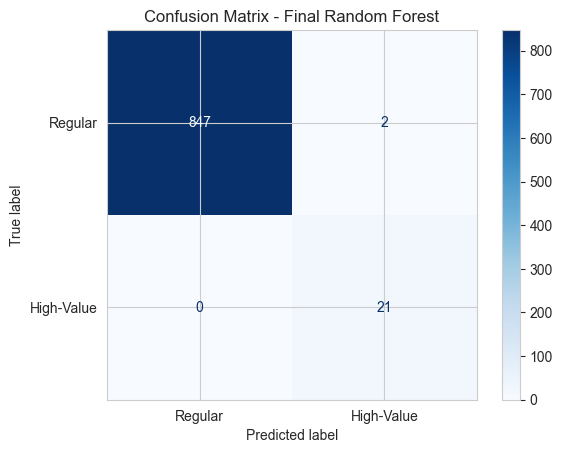

C:\Users\Yulong\AppData\Local\Temp\ipykernel_26432\800480336.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


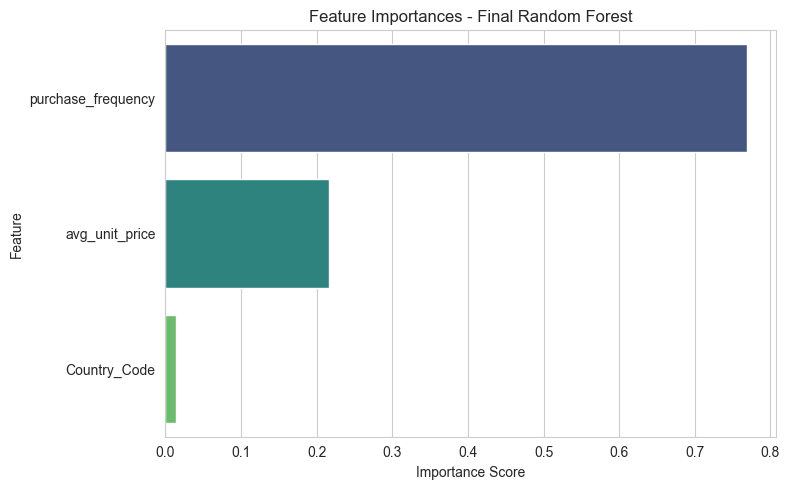

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Set confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=["Regular", "High-Value"],
    cmap="Blues",
    values_format='d'
)
plt.title("Confusion Matrix - Final Random Forest")
plt.show()

# Set feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importances - Final Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
